In [1]:

import sys
import sktime
import tqdm as tq
import xgboost as xgb
import matplotlib
import seaborn as sns
import sklearn as skl
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from tqdm import tqdm
from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.utils.plotting import plot_series
from xgboost import XGBRegressor

In [2]:
base_path = "/home/jinjinjara1022/"

weather_forecast_data_1 = pd.read_csv(base_path + "OBIC/data/기상예측데이터_1.csv")
jeju_power_market_day_ahead = pd.read_csv(base_path + "OBIC/data/제주전력시장_시장전기가격_하루전가격.csv")

In [3]:
weather_forecast_data_1 = weather_forecast_data_1[weather_forecast_data_1['location'] != 'location']
weather_forecast_data_1['ts'] =  pd.to_datetime(weather_forecast_data_1['ts'], unit='s')
weather_forecast_data_1['base_ts'] = pd.to_datetime(weather_forecast_data_1['base_ts'], unit='s')

/tmp/ipykernel_2572870/796732019.py:2: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  weather_forecast_data_1['ts'] =  pd.to_datetime(weather_forecast_data_1['ts'], unit='s')
/tmp/ipykernel_2572870/796732019.py:3: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  weather_forecast_data_1['base_ts'] = pd.to_datetime(weather_forecast_data_1['base_ts'], unit='s')


In [4]:
# 평균을 구할 열 리스트
columns_to_average = [
    'temp', 'real_feel_temp', 'wet_bulb_temp', 'dew_point', 
    'wind_dir', 'wind_spd', 'wind_gust_spd', 'rel_hum', 'vis', 
    'ceiling', 'uv_idx', 'precip_prob', 'rain_prob', 'snow_prob', 
    'ice_prob', 'total_liq', 'rain', 'snow', 'ice', 'cld_cvr'
]

# 숫자형으로 변환할 수 있는 값만 변환
weather_forecast_data_1[columns_to_average] = weather_forecast_data_1[columns_to_average].apply(pd.to_numeric, errors='coerce')

In [5]:
# 'ts'로 그룹화하여 각 열의 평균 계산
average_df = weather_forecast_data_1.groupby('ts', as_index=False)[columns_to_average].mean()

weather_df = average_df

ahead_df = jeju_power_market_day_ahead

ahead_df['ts'] = pd.to_datetime(ahead_df['ts'], unit='s')

In [6]:
df = pd.merge(weather_df, ahead_df, on='ts')

In [7]:
df['hour'] = df['ts'].dt.hour
df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)

df['month'] = df['ts'].dt.month
df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)

df['day_of_week'] = df['ts'].dt.dayofweek
df['day_of_week_sin'] = np.sin(2 * np.pi * df['day_of_week'] / 7)
df['day_of_week_cos'] = np.cos(2 * np.pi * df['day_of_week'] / 7)

In [8]:
df.rename(columns={
    '하루전가격(원/kWh)': 'previous_price_kwh'
}, inplace=True)

In [9]:
df = df.drop(['ts','hour', 'month', 'day_of_week'], axis=1)

In [10]:
df['previous_day_price'] = df['previous_price_kwh'].shift(24)
df['previous_2day_price'] = df['previous_price_kwh'].shift(48)
df['previous_3day_price'] = df['previous_price_kwh'].shift(72)

In [11]:
df = df[72:]

In [12]:
y = df['previous_price_kwh']
x = df.drop(['previous_price_kwh'], axis=1)

In [13]:
y_train, y_valid, x_train, x_valid = temporal_train_test_split(y = y, X = x, test_size = int(len(y) * 0.1))
print('train data shape\nx:{}, y:{}'.format(x_train.shape, y_train.shape))

train data shape
x:(5013, 29), y:(5013,)


In [14]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

# 스케일링할 열 선택
columns_to_scale = [
    'temp', 'real_feel_temp', 'wet_bulb_temp', 'dew_point',
    'wind_dir', 'wind_spd', 'wind_gust_spd', 'rel_hum',
    'vis', 'ceiling', 'uv_idx', 'precip_prob', 'rain_prob',
    'snow_prob', 'ice_prob', 'total_liq']

# Min-Max Scaler 초기화
scaler = MinMaxScaler()

# 선택한 열에 대해 Min-Max 스케일링 적용
x_train[columns_to_scale] = scaler.fit_transform(x_train[columns_to_scale])
x_valid[columns_to_scale] = scaler.transform(x_valid[columns_to_scale])

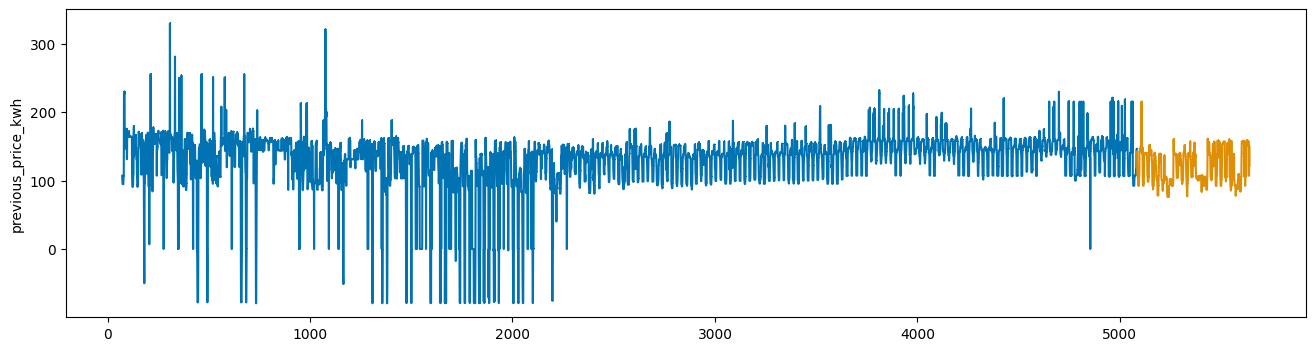

In [15]:
plot_series(y_train, y_valid, markers=[',' , ','])
plt.show()

In [16]:
# Define SMAPE loss function
def SMAPE(true, pred):
    return np.mean((np.abs(true-pred))/(np.abs(true) + np.abs(pred))) * 100

def weighted_mse(alpha = 1):
    def weighted_mse_fixed(label, pred):
        residual = (label - pred).astype("float")
        grad = np.where(residual>0, -2*alpha*residual, -2*residual)
        hess = np.where(residual>0, 2*alpha, 2.0)
        return grad, hess
    return weighted_mse_fixed

import xgboost as xgb
print(xgb.__version__)

2.1.1


In [20]:
xgb_reg = XGBRegressor(
    n_estimators=500,
    learning_rate=0.05,
    min_child_weight=1,
    max_depth=5,
    colsample_bytree=0.7,
    subsample=0.7,
    tree_method='hist',
    device='cuda:0',
    seed=0,
    early_stopping_rounds=50
)

xgb_reg.fit(
    x_train, y_train,
    eval_set=[(x_train, y_train), (x_valid, y_valid)],
    verbose=False
)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.7, device='cuda:0', early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.05, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=1, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=500, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [21]:
pred = xgb_reg.predict(x_valid)
pred = pd.Series(pred)
pred.index = np.arange(y_valid.index[0], y_valid.index[-1]+1)

SMAPE : 4.96380839361712


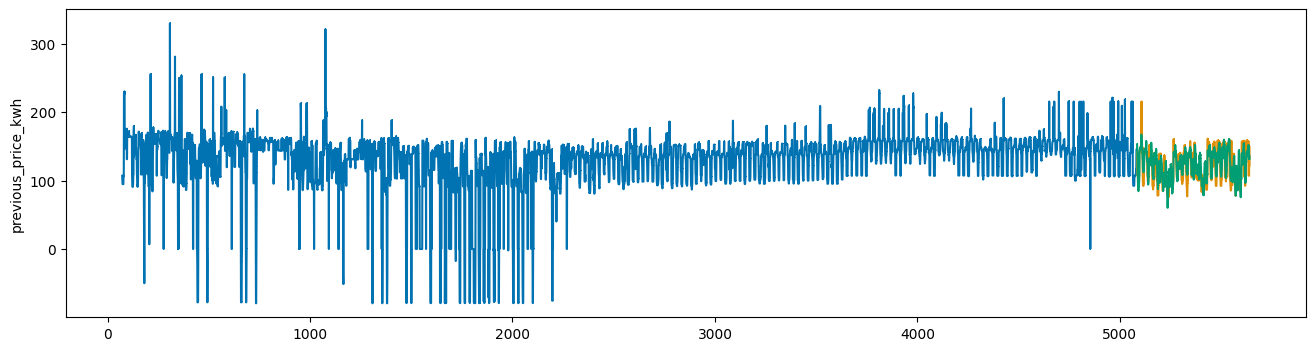

In [22]:
plot_series(y_train, y_valid, pd.Series(pred), markers=[',' , ',', ','])

print('SMAPE : {}'.format(SMAPE(y_valid, pred)))

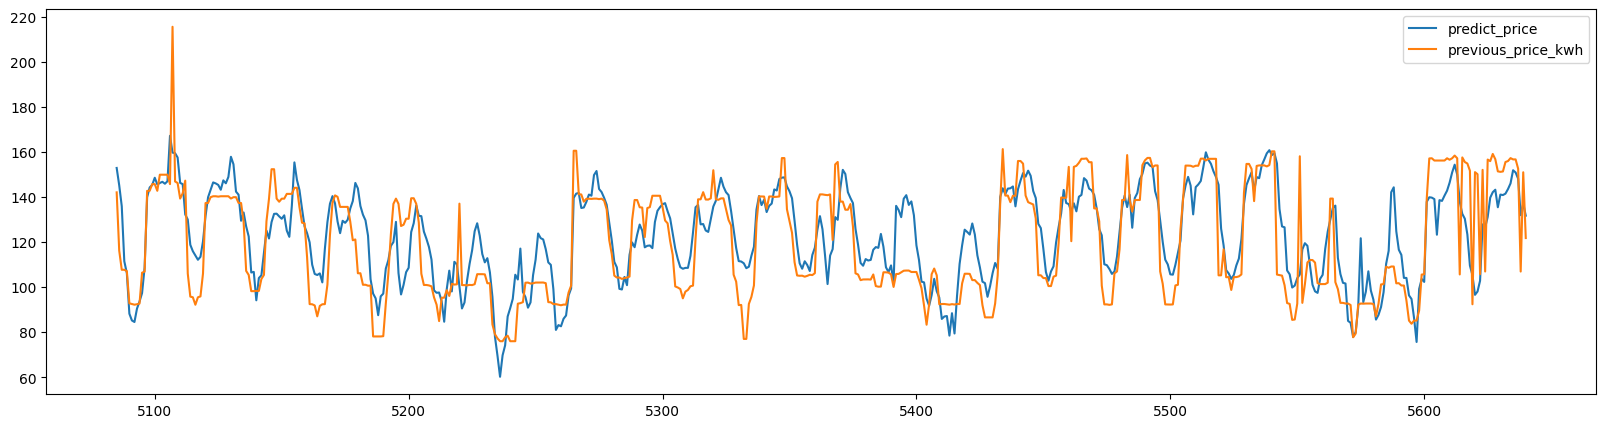

In [23]:
plt.figure(figsize=(20, 5))
pred.plot(label='predict_price')
y_valid.plot()
plt.legend()
plt.show()

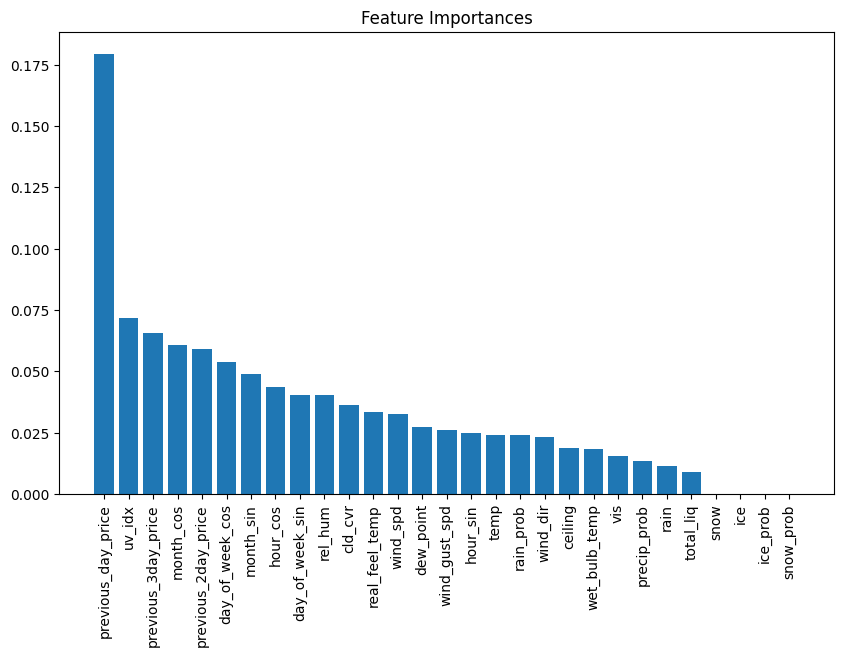

In [24]:
# 모델 학습 후 피처 중요도 추출
importances = xgb_reg.feature_importances_

# 중요도를 기준으로 피처를 내림차순 정렬
indices = np.argsort(importances)[::-1]
sorted_importances = importances[indices]
sorted_features = np.array(x_train.columns)[indices]

# 피처 중요도 시각화
plt.figure(figsize=(10, 6))
plt.title("Feature Importances")
plt.bar(range(len(sorted_importances)), sorted_importances)
plt.xticks(range(len(sorted_importances)), sorted_features, rotation=90)
plt.show()

In [35]:
from xgboost import XGBRegressor

threshold = 0.001  # 예: 중요도 0.01 미만 피처 제거
selected_features = sorted_features[sorted_importances > threshold]
x_train_selected = x_train[selected_features]
x_valid_selected = x_valid[selected_features]

In [36]:
xgb_reg = XGBRegressor(
    n_estimators=500,
    learning_rate=0.01, 
    min_child_weight=0.5,
    max_depth=6,
    colsample_bytree=0.8,
    subsample=0.8,
    tree_method='hist',
    device='cuda:1',
    seed=0,
    early_stopping_rounds=50
)

xgb_reg.fit(
    x_train_selected, y_train, 
    eval_set=[(x_train_selected, y_train), (x_valid_selected, y_valid)], 
    verbose=False
)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device='cuda:1', early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=6, max_leaves=None,
             min_child_weight=0.5, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=500, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [37]:
pred = xgb_reg.predict(x_valid_selected)
pred = pd.Series(pred)
pred.index = np.arange(y_valid.index[0], y_valid.index[-1]+1)

SMAPE : 5.627145372660244


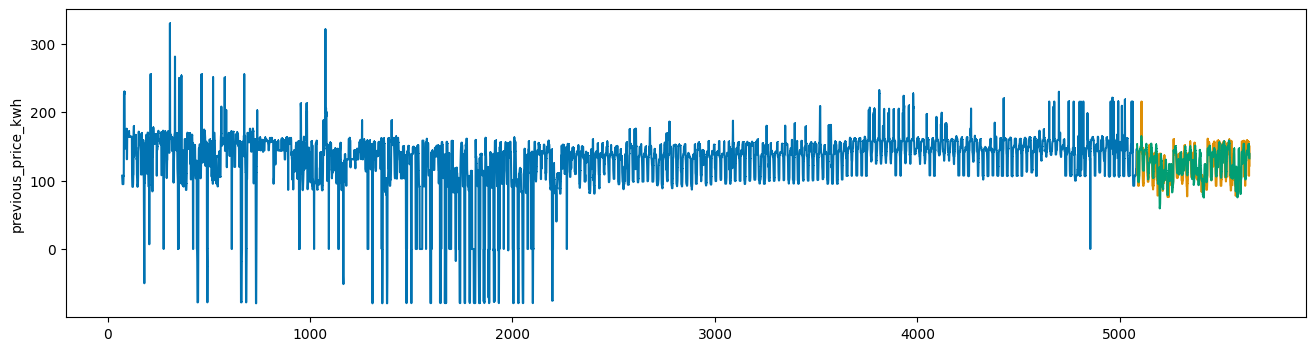

In [38]:
plot_series(y_train, y_valid, pd.Series(pred), markers=[',' , ',', ','])

print('SMAPE : {}'.format(SMAPE(y_valid, pred)))

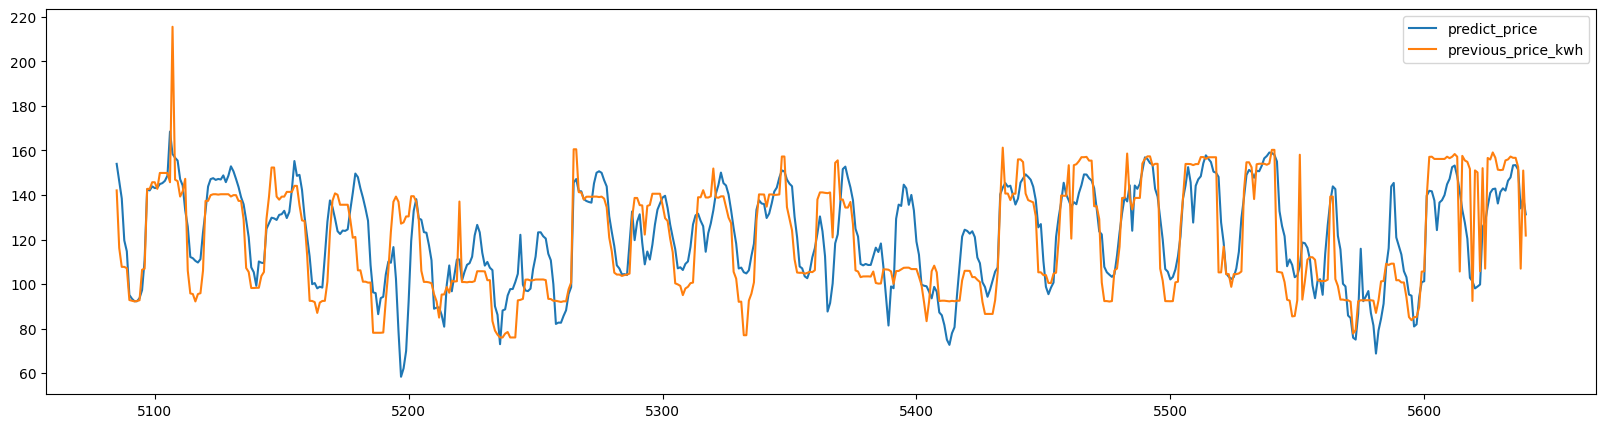

In [27]:
plt.figure(figsize=(20, 5))
pred.plot(label='predict_price')
y_valid.plot()
plt.legend()
plt.show()